# CSE547 - Colab 6
## node2vec

Adapted from Stanford's CS246

### Setup

First of all, we install the [nodevectors library](https://github.com/VHRanger/graph2vec) which offers a fast implementation of the node2vec method.

If you are curious to learn how to implement fast random walks on graphs, I recommend you to [read the blog post](https://www.singlelunch.com/2019/08/01/700x-faster-node2vec-models-fastest-random-walks-on-a-graph/) which explains some of the design choices behind this library.

In [1]:
!pip install nodevectors 

We now import the library, and create a small wrapper class which will expose only the few hyperparameters we will need to tune in this Colab

In [0]:
from nodevectors.embedders import Node2Vec
import networkx as nx

class Node2Vec(Node2Vec):
  """
  Parameters
  ----------
  p : float
      p parameter of node2vec
  q : float
      q parameter of node2vec
  d : int
      dimensionality of the embedding vectors
  """
  def __init__(self, p=1, q=1, d=32):
    super().__init__(
                     walklen=10,
                     epochs=50,
                     n_components=d,
                     return_weight=1.0/p,
                     neighbor_weight=1.0/q,
                     threads=0,
                     w2vparams={'window': 4,
                                'negative': 5, 
                                'iter': 10,
                                'ns_exponent': 0.5,
                                'batch_words': 128})

Lastly, let's import some of the common libraries needed for our task.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Example

In the example below, we will use Zachary's Karate Club to demonstrate the power of node2vec. 

In [4]:
# Load the Zachary's Karate Club as a NetworkX Graph object
KCG = nx.karate_club_graph()

# Fit embedding model to the Karate Club graph
n2v = Node2Vec(1, 1, 2)
n2v.fit(KCG)

Making walks... Done, T=1.91
Mapping Walk Names... Done, T=0.03
Training W2V... Done, T=0.26


In [0]:
embeddings = []
for node in KCG.nodes:
  embedding = list(n2v.predict(node))
  club = KCG.nodes[node]['club']
  embeddings.append(embedding + [club])

# Construct a pandas dataframe with the 2D embeddings from node2vec,
# plus the club name that each node belongs to after the split
df = pd.DataFrame(embeddings, columns=['x', 'y', 'club'])

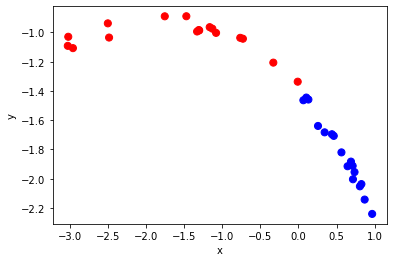

In [6]:
# Nodes who stayed with the Mr. Hi will be plotted in red, while nodes
# who moved with the Officer will be plotted in blue
colors = ['red' if x == 'Mr. Hi' else 'blue' for x in df.club]
df.plot.scatter(x='x', y='y', s=50, c=colors)

If our example trained correctly, you should notice a clear separation between the blue and red nodes.  Solely from the graph structure, node2vec could predict how the Zachary's Karate Club split!

Tune the hyperparameters ```p``` and ```q```, and notice how they affect the resulting embeddings.

### Your Task

Now we will study the behavior of node2vec on [barbell graphs](https://en.wikipedia.org/wiki/Barbell_graph).

Below you can see a toy example of a barbell graph generated with NetworkX ( [nx.barbell_graph](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.classic.barbell_graph.html#networkx.generators.classic.barbell_graph) ).

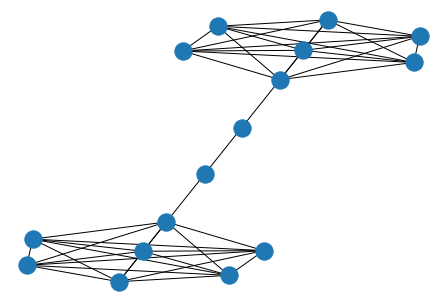

In [7]:
toy_barbell = nx.barbell_graph(7, 2)
nx.draw_kamada_kawai(toy_barbell)

Above is a barbell graph with a 2 node path inbetween two complete graphs. 

Generate a larger barbell graph, where each complete graph has exactly 1000 nodes, and there are no nodes in the path inbetween them (i.e., all the nodes in the barbell graph belong to either one of the two complete graphs, and the connecting path does not have any internal node).

Then, learn node2vec embeddings on this graph, setting ```p = 1, q = 1``` and ```d = 10```.

In [23]:
large_barbell = nx.barbell_graph(1000,0)
# Generate walks
m1 = Node2Vec(p = 1, q = 1, d = 10)
m1.fit(large_barbell)

Making walks... Done, T=0.40
Mapping Walk Names... Done, T=0.69
Training W2V... Done, T=20.38


In [22]:
display(nx.number_of_nodes(large_barbell))
display(nx.number_of_edges(large_barbell))

2001

999002

Generate another barbell graph, this time adding a path of 50 nodes between the two complete graphs.

Learn the node2vec embeddings for the nodes of this new graph, using the same hyperparameters as before.

In [14]:
# YOUR CODE HERE
large_barbell2 = nx.barbell_graph(1000, 50)
# Generate walks
m2 = Node2Vec(p = 1, q = 1, d = 10)
m2.fit(large_barbell2)


Making walks... Done, T=0.40
Mapping Walk Names... Done, T=0.71
Training W2V... Done, T=19.84


In [11]:
display(nx.number_of_nodes(large_barbell2))
display(nx.number_of_edges(large_barbell2))


2050

999051

Now write a function that takes as input a node id ```n``` in the graph (e.g., ```5```) and returns a list containing the cosine similarity between the node2vec vector obtained from `model.predict(...)` of the input node ```n``` and all the nodes in the given barbell graph (including the similarity with ```n``` itself).

In [0]:
# YOUR CODE HERE
def cossim(n,graph, vec):
  node = vec.predict(n)
  d = []
  for i in range(graph.number_of_nodes()):
    nodei = vec.predict(i)
    d.append( np.dot(node, nodei)/(np.linalg.norm(node)*np.linalg.norm(nodei)))
  return d


For each of the graphs you generated earlier (0 Node Path, 50 Node Path), find how many nodes have exactly 1000 neighbors and how many nodes have less than 100 neighbors.

Two nodes are defined as neighbors if their cosine similarity is greater than 0.8.

In [28]:
# YOUR CARE HERE
count1k = 0
count100 = 0
model=m1
graph = large_barbell
for i in range(graph.number_of_nodes()):
  d = cossim(i, graph, model)
  check = len([n for n in d if n>0.8])
  if check==1000:
    count1k+=1
  elif check<100:
    count100+=1

print(count1k)
print(count100)

2000
0


In [29]:
# YOUR CARE HERE
count1k = 0
count100 = 0
model=m2
graph = large_barbell2
for i in range(graph.number_of_nodes()):
  d = cossim(i, graph, model)
  check = len([n for n in d if n>0.8])
  if check==1000:
    count1k+=1
  elif check<100:
    count100+=1

print(count1k)
print(count100)

0
52


Once you have working code for each cell above, **head over to Gradescope, read carefully the questions, and submit your solution for this Colab**!
